## Notebook for playing around with variables in experimental and master objects

In [92]:
%run ./rob_setup_notebook.ipynb

import utils.interareal_analysis as ia
import utils.interareal_plotting as ip
import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
from ia_funcs import *

from utils.paq2py import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Suite2p path: ['/home/rlees/Documents/Code/suite2p/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Plots 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


### Add or check attributes in all exp_obj pkl files

In [134]:
pkl_files = os.listdir(pkl_folder)

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)

        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
        
#             with open(pkl_path, 'wb') as f:
#                 pickle.dump(exp_obj, f)
                
#         pkl_list = [exp_obj.photostim_r, exp_obj.photostim_s]

#         if exp_obj.spont.n_frames > 0:
#             pkl_list.append(exp_obj.spont)

#         if exp_obj.whisker_stim.n_frames > 0:
#             pkl_list.append(exp_obj.whisker_stim)
        
#         for sub_obj in pkl_list:

### Play with data from individual experimental objects

In [22]:
# List of pickle object file names
# '2019-06-11_J048',
# '2019-06-13_J052',
# '2019-06-25_RL048',
# '2019-07-15_RL052',
# '2019-08-14_J058',
# '2019-08-14_J059',
# '2019-08-15_RL055',
# '2019-11-14_J061',
# '2019-11-14_J063',
# '2019-11-15_J064',
# '2019-11-18_J065',
# '2020-02-27_RL075',
# '2020-03-03_RL074',
# '2020-03-05_RL070',
# '2020-03-05_RL072',
# '2020-03-12_RL070',
# '2020-03-16_RL074',
# '2020-03-19_RL075',
# '2020-03-20_RL080'

pkl_path = os.path.join(pkl_folder, '2019-11-14_J061.pkl')

with open(pkl_path, 'rb') as f:
    exp_obj = pickle.load(f)
    
print('Loaded pickled object.')

sub_obj = exp_obj.photostim_r

Loaded pickled object.


### Show all attributes in exp_obj or sub_objs

In [4]:
# Show all attributes in exp_obj or sub_objs
print('Session object attributes')
for key, value in vars(exp_obj).items():
    print(key)

print('\nExperimental object attributes')
for key, value in vars(exp_obj.photostim_r).items():
    print(key)

Session object attributes
ss_id
sheet_name
s2p_path
photostim_r
photostim_s
whisker_stim
spont
frame_list

Experimental object attributes
tiff_path
naparm_path
paq_path
sheet_name
s2p_path
stim_channel
stim_type
fps
frame_x
frame_y
n_planes
pix_sz_x
pix_sz_y
scan_x
scan_y
zoom
n_frames
last_good_frame
n_groups
n_reps
n_shots
n_trials
inter_point_delay
spiral_size
single_stim_dur
stim_dur
frame_clock
stim_times
stim_start_frames
duration_frames
frames
cell_id
n_units
cell_plane
cell_med
cell_s1
cell_x
cell_y
raw
dfof
mean_img
xoff
yoff
all_trials
all_amplitudes
stas
sta_amplitudes
t_tests
pre_frames
post_frames
test_frames
single_sig
sta_sig
sta_sig_nomulti
target_coords
n_targets
target_areas
targeted_cells
n_targeted_cells


### Grand mean trial dF/F function

In [63]:
def plotExpAvgDff(sub_obj, threshold, cell_ids=False):
    
    if not cell_ids:
        cell_ids = range(sub_obj.all_trials[0].shape[0])
        
    # all trials for all cells of interest
    cell_trials = np.array(sub_obj.all_trials[0][cell_ids][:][:])
    # mean across all trials for each cell
    cell_trial_means = np.mean(cell_trials, axis=2)

    # collapse trial mean for each cell in to one number, the overall mean dff
    cell_mean = np.mean(cell_trial_means, axis=1)
    
    # find mean dff greater than threshold and filter out
    extreme_means = np.where(abs(cell_mean) > threshold)
    if len(extreme_means[0]) > 0:
        print(len(extreme_means[0]), 'extreme values excluded')
    cell_trial_means = np.delete(cell_trial_means, extreme_means, axis=0)
    
    # make mean and std of traces
    grand_trial_mean = np.mean(cell_trial_means, axis=0)
    grand_trial_std = np.std(cell_trial_means, axis=0)
    grand_trial_ci = 1.960 * (grand_trial_std/np.sqrt(len(cell_ids)))
    grand_trial_sem = grand_trial_std/np.sqrt(len(cell_ids))
    
    # construct patch to cover stim artifact period
#     stim_patch = patches.Rectangle((0,-100), sub_obj.duration_frames/fps, 999, zorder=3, color='lightgrey', lw=3, ec='white')
#     ax = plt.gca()
#     ax.add_patch(stim_patch)
    
    # make x axis in continous time units instead of frames
    fps = sub_obj.fps
    x = np.array(range( -sub_obj.pre_frames , sub_obj.duration_frames + sub_obj.post_frames ))/fps
    
    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)
    
    #construct plot
    plt.plot(x, grand_trial_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_trial_mean + grand_trial_sem, grand_trial_mean - grand_trial_sem, alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.15, 0.15]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
    return cell_trial_means

### Plot grand mean trial dF/F (pooled cells and trial repeats, separated each trial type and session/animal)

/home/rlees/mnt/qnap/pkl_files/2020-03-12_RL070.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-16_RL074.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-19_RL075.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
/home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl


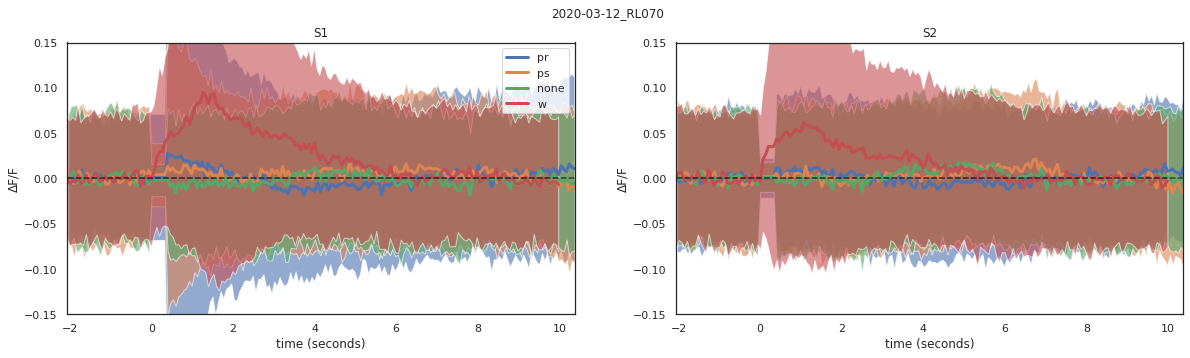

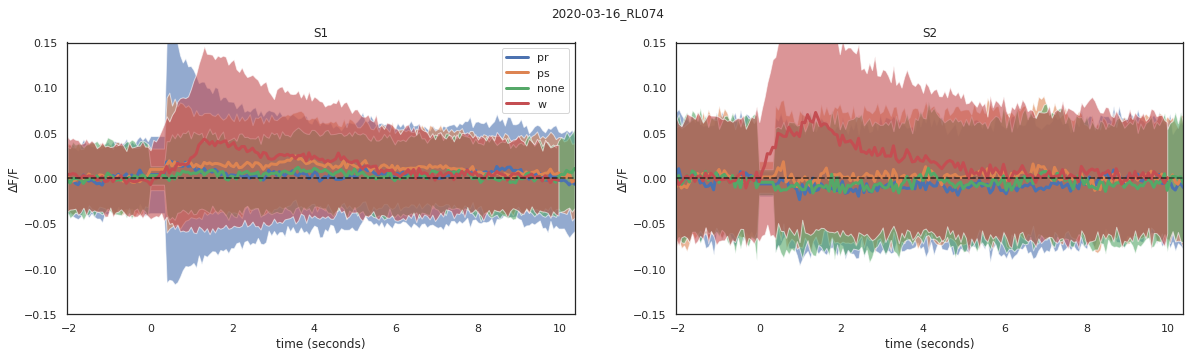

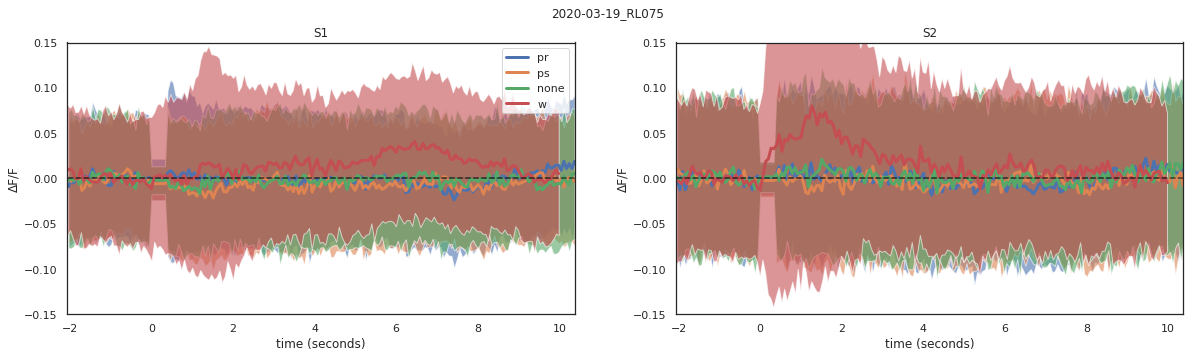

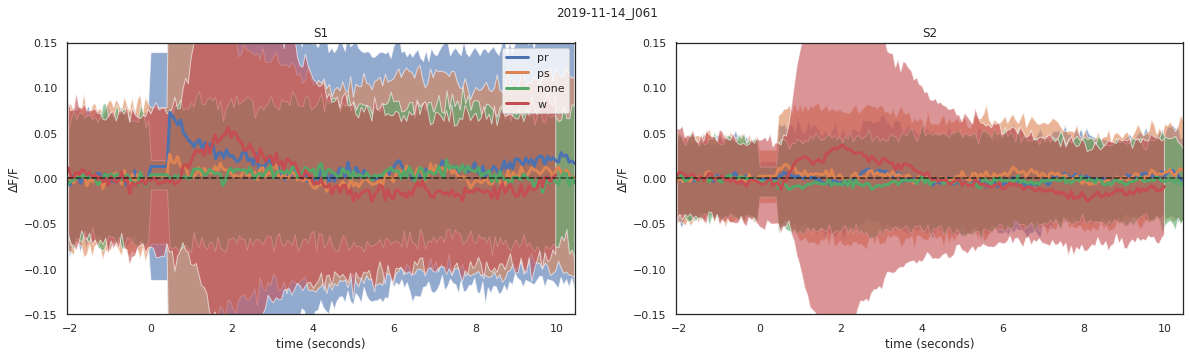

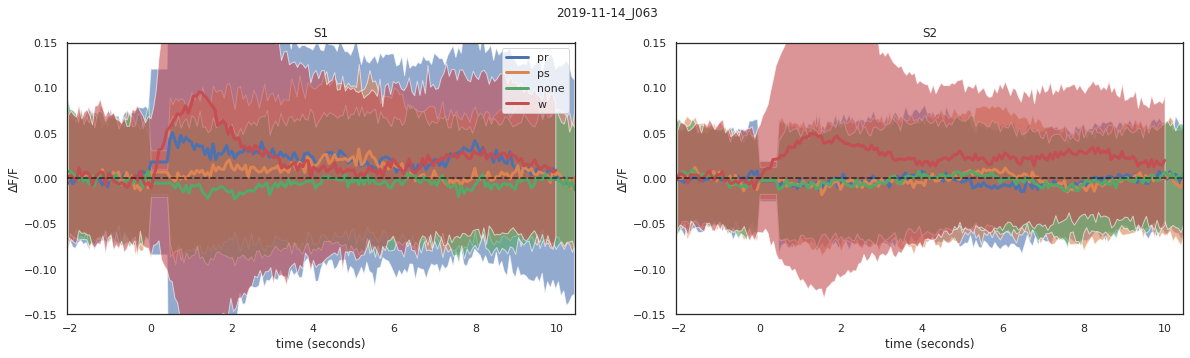

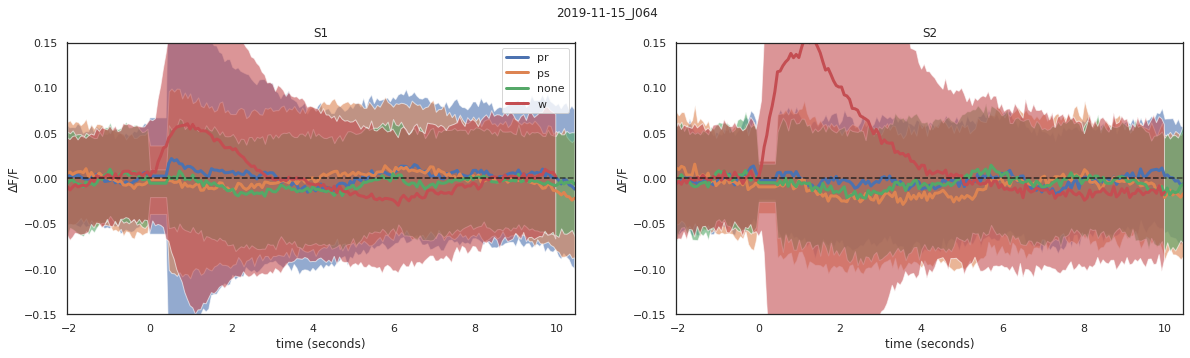

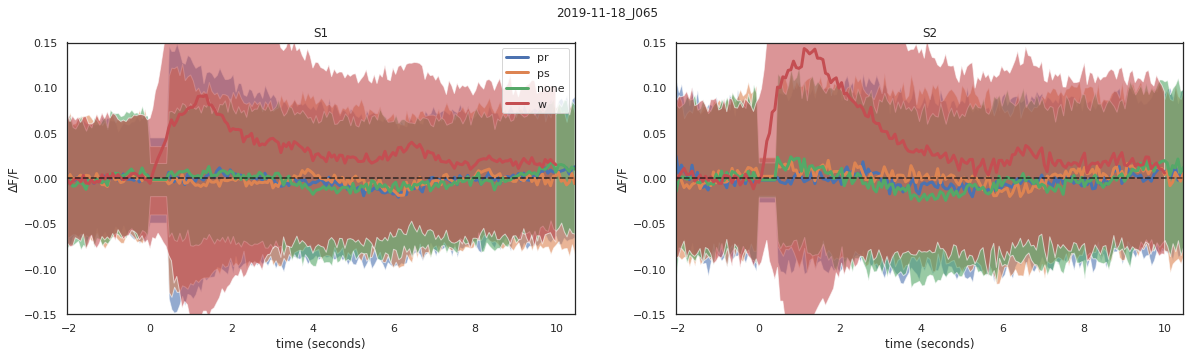

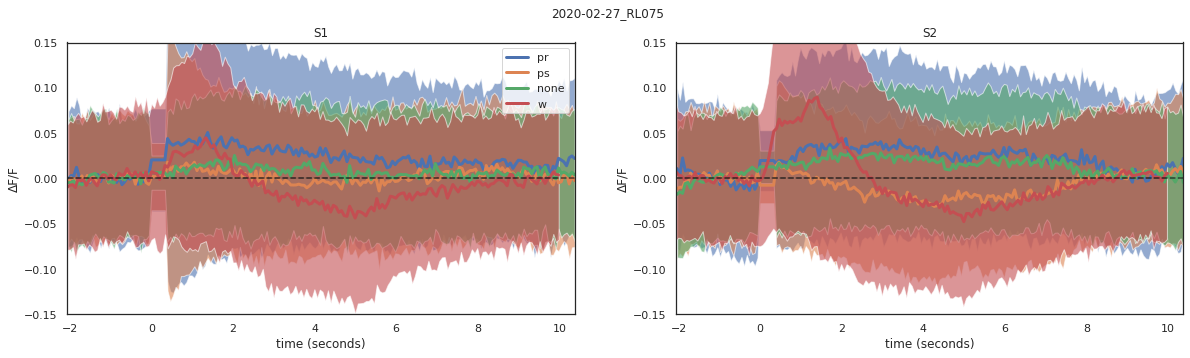

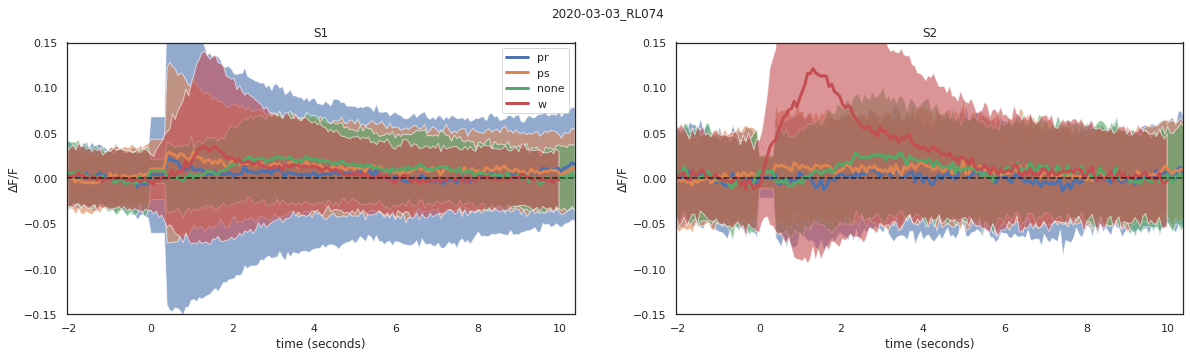

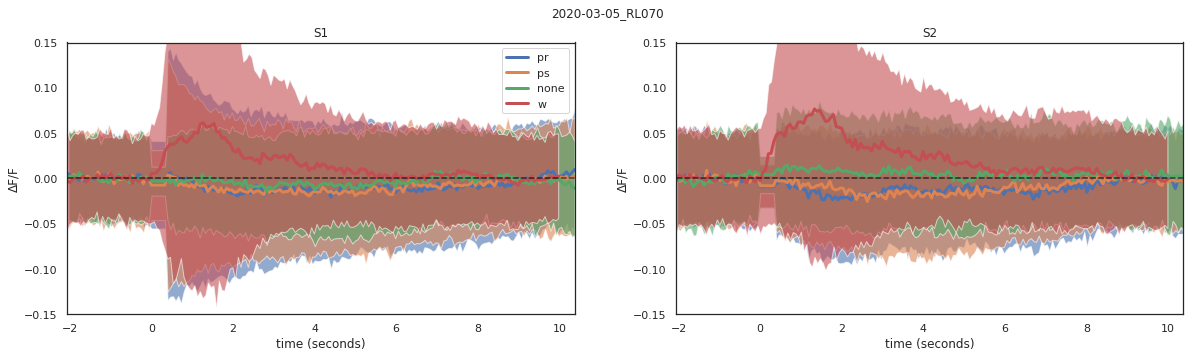

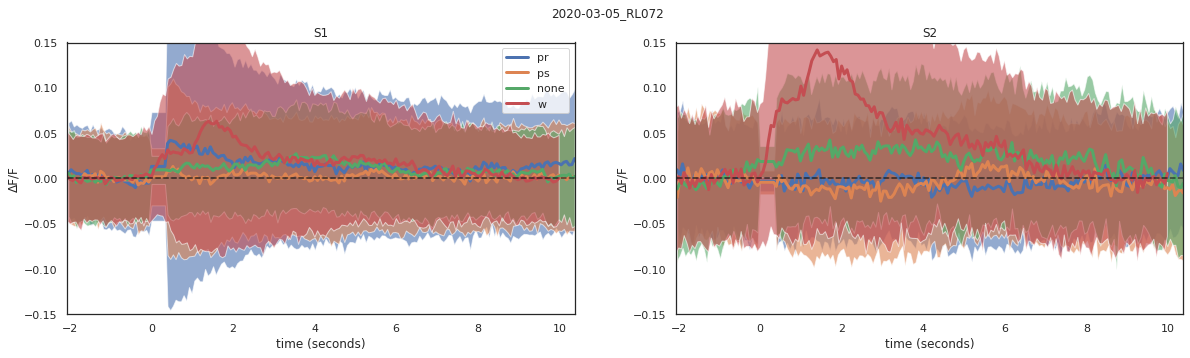

In [90]:
pkl_files = os.listdir(pkl_folder)

threshold = 10

grand_average = []

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)
        print(pkl_path)

        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)

        pkl_list = [exp_obj.photostim_r, exp_obj.photostim_s]

        if exp_obj.spont.n_frames > 0:
            pkl_list.append(exp_obj.spont)

        if exp_obj.whisker_stim.n_frames > 0:
            pkl_list.append(exp_obj.whisker_stim)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        labels = []
        
        for i, ax_id in enumerate([1,0]):
            
            in_s1 = np.array(exp_obj.photostim_r.cell_s1[0])
            cell_ids = np.where(in_s1 == i)
            
            plt.sca(ax[ax_id])
            plt.title('S' + str(ax_id+1))
            
            for sub_obj in pkl_list:
            
                labels.append(sub_obj.stim_type)
                cell_trials = plotExpAvgDff(sub_obj, threshold, cell_ids=cell_ids)
                grand_average.append(cell_trials)
        
        fig.suptitle(sub_obj.sheet_name)
        plt.legend(labels[:4], loc='upper right')
#         plt.savefig(os.path.join(fig_save_path, 'trial_avg_dff_traces_detrended', exp_obj.sheet_name + '_grand_trial_avg_s1s2_detrend.png'))
#         plt.savefig(os.path.join(fig_save_path, 'trial_avg_dff_traces_detrended', exp_obj.sheet_name + '_grand_trial_avg_s1s2_detrend.svg'))

### Plot grand mean dF/F (pooled animals, cells and trials, separated trial type)

4557 s1 cells
3860 s2 cells


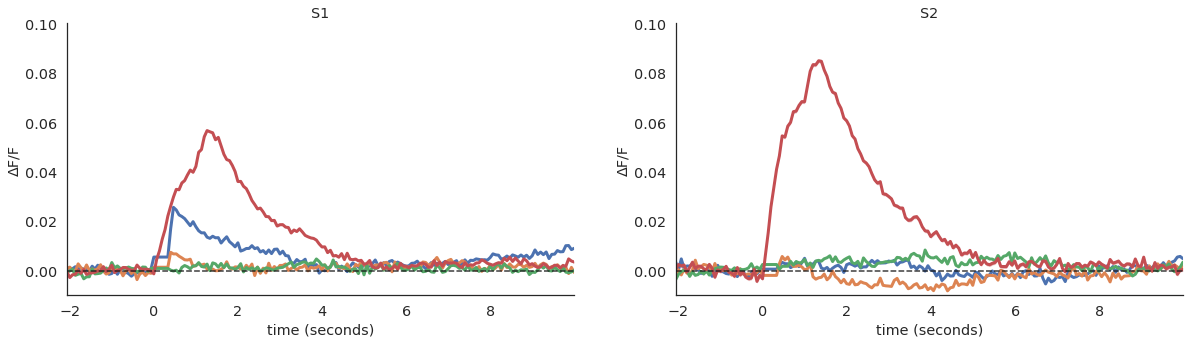

In [94]:
min_frames = np.inf
for avg in grand_average:
    curr_frames = np.size(avg, axis=1)
    if curr_frames < min_frames:
        min_frames = curr_frames
        
s2_pr = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[::8]]), axis=0)
s2_ps = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[1::8]]), axis=0)
s2_none = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[2::8]]), axis=0)
s2_w = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[3::8]]), axis=0)

s1_pr = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[4::8]]), axis=0)
s1_ps = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[5::8]]), axis=0)
s1_none = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[6::8]]), axis=0)
s1_w = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[7::8]]), axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plt.sca(ax[0])
plt.title('S1')

for trials in [s1_pr, s1_ps, s1_none, s1_w]:
    
    grand_mean = np.mean(trials, axis=0)
    grand_std = np.std(grand_mean, axis=0)
    grand_ci = 1.960 * (grand_std/np.sqrt(trials.shape[0]))
    grand_sem = grand_std/np.sqrt(trials.shape[0])

    fps = sub_obj.fps
    x = np.array(range( -sub_obj.pre_frames , sub_obj.duration_frames + sub_obj.post_frames ))/fps

    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)

    #construct plot
    plt.plot(x, grand_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_mean + grand_ci, grand_mean - grand_ci, alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.01, 0.1]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
plt.sca(ax[1])
plt.title('S2')

for trials in [s2_pr, s2_ps, s2_none, s2_w]:
    
    grand_mean = np.mean(trials, axis=0)
    grand_std = np.std(grand_mean, axis=0)
    grand_ci = 1.960 * (grand_std/np.sqrt(trials.shape[0]))
    grand_sem = grand_std/np.sqrt(trials.shape[0])

    fps = sub_obj.fps
    x = np.array(range( -sub_obj.pre_frames , sub_obj.duration_frames + sub_obj.post_frames ))/fps

    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)

    #construct plot
    plt.plot(x, grand_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_mean + grand_ci, grand_mean - grand_ci, alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.01, 0.1]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
print(s1_w.shape[0], 's1 cells')
print(s2_w.shape[0], 's2 cells')

plt.savefig(os.path.join(fig_save_path, 'grand_avg_traces_detrended', 'grand_mean_ci_deepnshallow_s1s2.png'))
plt.savefig(os.path.join(fig_save_path, 'grand_avg_traces_detrended', 'grand_mean_ci_deepnshallow_s1s2.svg'))

### Plot positive and negative amplitudes in space (pooled trial repeats, separated trial type, session and cell)

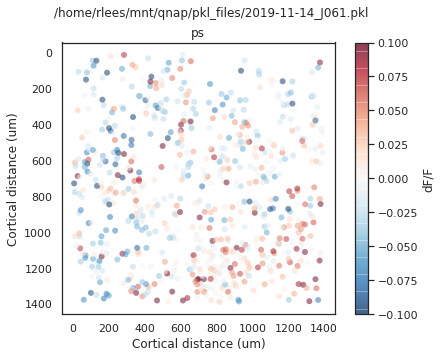

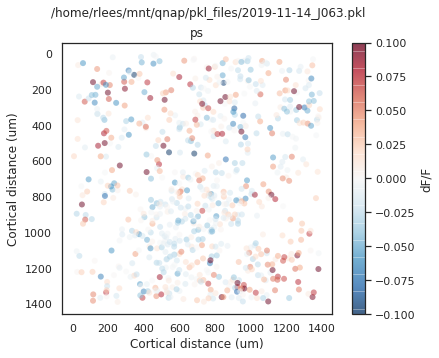

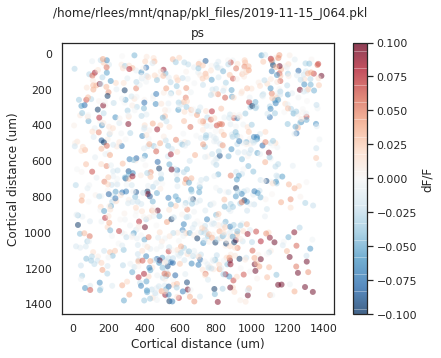

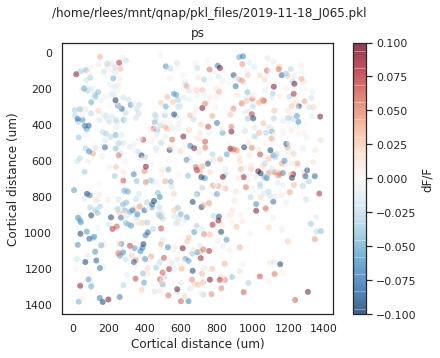

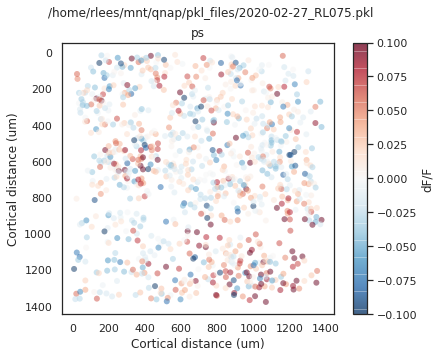

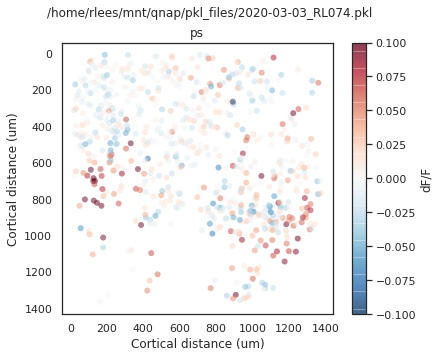

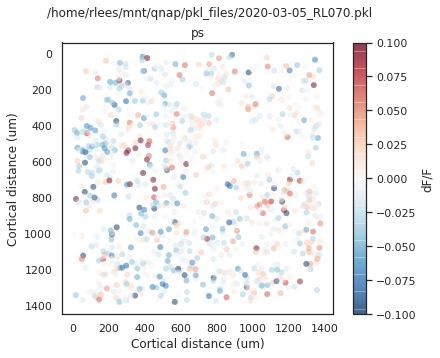

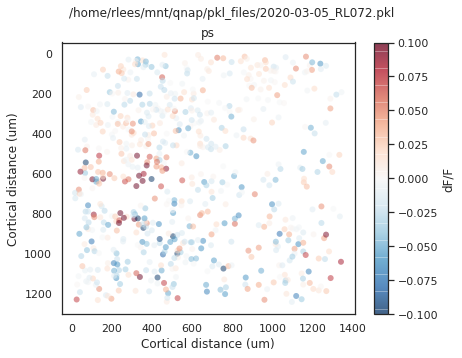

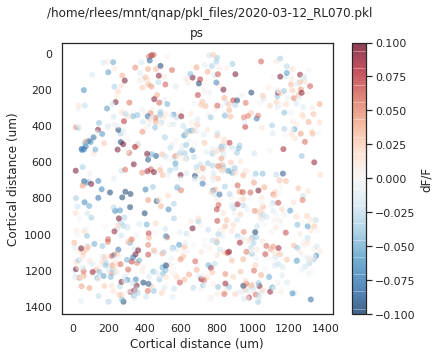

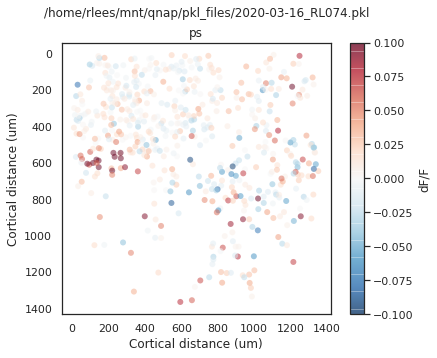

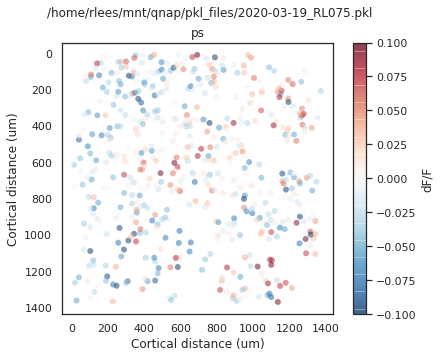

In [18]:
# plot sta excitation and inhibition in space 

pkl_files = os.listdir(pkl_folder)

all_amps = []
all_dists = []
all_x = []
all_y = []

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)

        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
        
        pkl_list = []
#         pkl_list.append(exp_obj.photostim_r)
        pkl_list.append(exp_obj.photostim_s)
        
#         if exp_obj.whisker_stim.n_frames > 0:
#             pkl_list.append(exp_obj.whisker_stim)
            
#         if exp_obj.spont.n_frames > 0:
#             pkl_list.append(exp_obj.spont)
        
        fig = plt.figure(figsize=(7*len(pkl_list),5))
        fig.suptitle(pkl_path)
        
        for i,sub_obj in enumerate(pkl_list):
            
            followers = []

            for cell in range(sub_obj.n_units[0]):
                cell_coord = sub_obj.cell_med[0][cell]
                
                if sub_obj.stim_type is 'w':
                    followers.append(([cell_coord[1],cell_coord[0]], sub_obj.sta_amplitudes[0][cell]))
                elif sub_obj.stim_type is 'none':
                    if exp_obj.photostim_r.targeted_cells[cell]==0:
                        followers.append(([cell_coord[1],cell_coord[0]], sub_obj.sta_amplitudes[0][cell]))
                else:
                    if sub_obj.targeted_cells[cell]==0:
                        followers.append(([cell_coord[1],cell_coord[0]], sub_obj.sta_amplitudes[0][cell]))
                
#             tree = spatial.KDTree(sub_obj.target_coords)

            norm_x = []
            norm_y = []
            amps = []
            dists = []

            for coord, amp in followers:
#                 dist, index = tree.query(coord)
#                 x,y = np.subtract(coord, sub_obj.target_coords[index])
#                 norm_x.append(x)
#                 norm_y.append(y)
#                 dists.append(dist)
                amps.append(amp)
                
                norm_x.append(coord[0])
                norm_y.append(coord[1])
                                
            x_um = [x*sub_obj.pix_sz_x for x in norm_x]
            y_um = [y*sub_obj.pix_sz_y for y in norm_y]
            ax = fig.add_subplot(1, len(pkl_list), i+1)
            sc = ax.scatter(x_um, y_um, c=amps, cmap='RdBu_r', vmin=-0.1, vmax=0.1, alpha=0.5, linewidth=0)
            
            ax.set_aspect('equal')
            ax.set_xlabel('Cortical distance (um)')
            ax.set_ylabel('Cortical distance (um)')
            ax.set_title(sub_obj.stim_type)
            ax.set_ylim(ax.get_ylim()[::-1])
    
            all_amps.extend(amps)
            all_dists.extend(np.absolute(dists))
            all_x.extend(x_um)
            all_y.extend(y_um)
            
        cb = plt.colorbar(sc, ax=ax)
        cb.set_label('dF/F')
        
#         plt.savefig(os.path.join(fig_save_path, 'spatial_responses', pkl[:-4] + '_spont_dFF_spatial.png'))
#         plt.savefig(os.path.join(fig_save_path, 'spatial_responses', pkl[:-4] + '_spont_dFF_spatial.svg'))

### Function for plotting average responses in space

In [19]:
def binned_amplitudes_2d(all_x, all_y, all_amps):
    all_amps_real = np.nan_to_num(all_amps)
    denominator, xedges, yedges = np.histogram2d(all_x, all_y, bins=30)
    numerator, _, _ = np.histogram2d(all_x, all_y, bins=30, weights=all_amps_real)
    h = numerator/denominator
    Y, X = np.meshgrid(xedges, yedges)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)
    mesh1 = ax[0].pcolormesh(X, Y, h, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax[0].set_xlabel('Cortical distance (um)')
    ax[0].set_ylabel('Cortical distance (um)')
    ax[0].set_aspect('equal')
    ax[0].set_ylim([1400, 0])
    ax[0].set_title('Binned responses (30 bins)')
    cb = plt.colorbar(mesh1, ax=ax[0])
    cb.set_label('dFF %')

    mesh2 = ax[1].pcolormesh(X, Y, denominator.astype(int), cmap='inferno', vmin=0, vmax=30)
    ax[1].set_xlabel('Cortical distance (um)')
    ax[1].set_ylabel('Cortical distance (um)')
    ax[1].set_aspect('equal')
    ax[1].set_ylim([1400, 0])
    ax[1].set_title('Number of cells in bin')
    cb = plt.colorbar(mesh2, ax=ax[1])
    cb.set_label('num cells')

### Plot average response to stim, binned in 2D (pooled animal and trial repeats, separated trial types)

/home/rlees/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


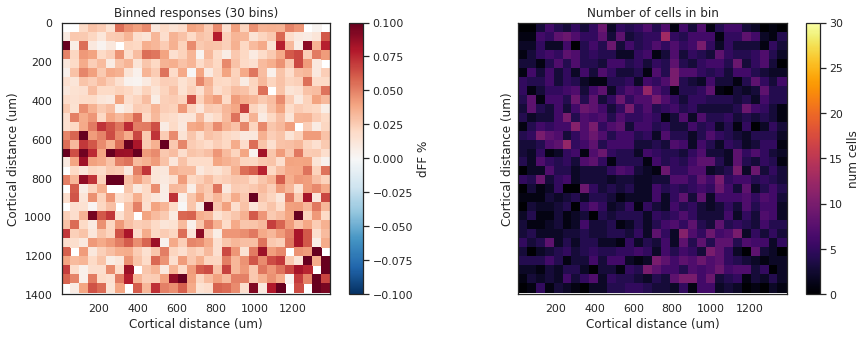

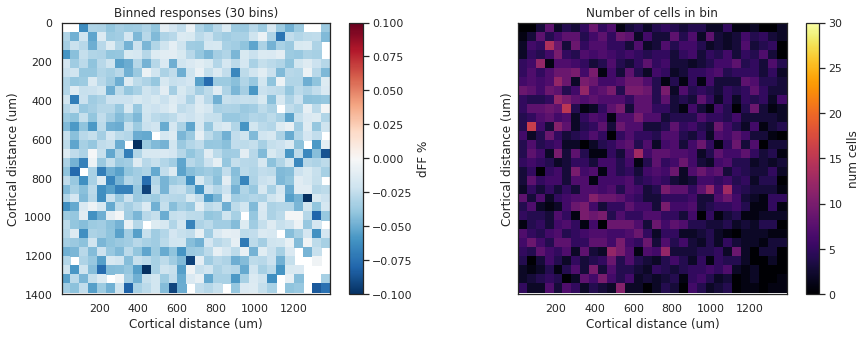

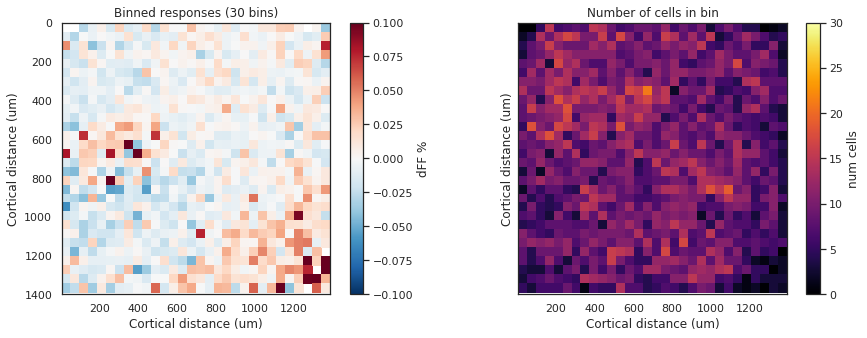

In [20]:
indices = [i for i,amp in enumerate(all_amps) if amp > 0]
x = [x for i,x in enumerate(all_x) if i in indices]
y = [y for i,y in enumerate(all_y) if i in indices]
pos_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

binned_amplitudes_2d(x, y, pos_amps)

indices = [i for i,amp in enumerate(all_amps) if amp < 0]
x = [x for i,x in enumerate(all_x) if i in indices]
y = [y for i,y in enumerate(all_y) if i in indices]
neg_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

binned_amplitudes_2d(x, y, neg_amps)

binned_amplitudes_2d(all_x, all_y, all_amps)

# plt.savefig(os.path.join(fig_save_path, 'avg_spatial_responses', 'BAFOV_ps_dFF_spatial.png'))
# plt.savefig(os.path.join(fig_save_path, 'avg_spatial_responses', 'BAFOV_ps_dFF_spatial.svg'))

### Play with whisker stim data

In [ ]:
# Calculate the number of cells that responded both to whisker stim and photostim

# a = np.where(exp_obj.whisker_stim.sta_sig[0])
# b = np.where(exp_obj.photostim_r.sta_sig[0])
# print(a,b)
# sum(1 for i in b[0] if i in a[0])

# Plot whisker stim trials where cells went over 200 dFF

plt.figure(figsize=(5,10))
sta_mean = []

for i, sta in enumerate(exp_obj.whisker_stim.stas[0]):
    if exp_obj.whisker_stim.sta_sig[0][i]:
        plt.plot(sta, alpha=0.2)
        sta_mean.append(sta)
    
        if exp_obj.whisker_stim.sta_amplitudes[0][i] > 200:
            print(exp_obj.whisker_stim.cell_id[0][i])
            
sta_mean = np.mean(sta_mean, axis=0)

plt.plot(sta_mean, 'k', linewidth=2);

plt.axis([0, 55, -10, 300]);

### Play with dataframes from master object

In [6]:
with open(master_path, 'rb') as f:
    master_obj = pickle.load(f)

df = master_obj.df
print(df.columns)

Index(['sheet_name', 'tiff_path', 'stim_type', 'fps', 'n_units', 's1_cells',
       's2_sta', 's2_sta_amp', 's2_sta_std', 's1_sta', 's1_sta_amp',
       's1_sta_std', 'num_s1_cells', 'num_s2_cells',
       'positive_s1_responders_trial', 'negative_s1_responders_trial',
       'positive_s2_responders_trial', 'negative_s2_responders_trial',
       'positive_s1_responders_sta', 'negative_s1_responders_sta',
       'positive_s2_responders_sta', 'negative_s2_responders_sta',
       'positive_s1_responders_sta_nomulti',
       'negative_s1_responders_sta_nomulti',
       'positive_s2_responders_sta_nomulti',
       'negative_s2_responders_sta_nomulti', 'prob_response', 'n_targets',
       'target_cells', 'n_targeted_cells', 'stim_dur', 'stim_freq',
       'target_sta', 'target_sta_amp', 'target_sta_std', 'non_target_sta',
       'non_target_sta_amp', 'non_target_sta_std', 'target_responders_trial',
       'target_responders_trial_sum', 'target_responders',
       'target_responders_sta', 'ta

In [7]:
df

,sheet_name,tiff_path,stim_type,fps,n_units,s1_cells,s2_sta,s2_sta_amp,s2_sta_std,s1_sta,...,non_target_sta_amp,non_target_sta_std,target_responders_trial,target_responders_trial_sum,target_responders,target_responders_sta,target_responders_sta_nomulti,target_sum_dff,num_whisker_targets,euclid_dist
0,2020-03-03_RL074,2020-03-03_RL074_t-005,pr,15.230163,703,"[True, True, True, True, True, True, True, Tru...","[0.0031109538, 0.0034287437, 0.0014365749, 0.0...",-0.000849,"[0.054167558, 0.054008517, 0.053149097, 0.0556...","[0.005409178, 0.00535365, 0.002886082, 0.00245...",...,-0.001064,"[0.046492606, 0.04539982, 0.043628197, 0.04481...","[[False, False, False, False, False, False, Fa...","[8, 9, 8, 8, 9, 9, 8, 9, 7, 6, 7, 10, 5, 7, 6,...","[False, False, False, False, False, False, Fal...",16.0,18.0,"[7.966341972351074, 11.889556884765625, 7.9293...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[108.73176930524951, 106.79750366990538, 132.2..."
1,2020-03-03_RL074,2020-03-03_RL074_t-006,ps,15.231754,703,"[True, True, True, True, True, True, True, Tru...","[-0.0040993835, -0.0010641889, -0.0029521757, ...",0.008712,"[0.04905566, 0.057080325, 0.05153678, 0.054075...","[0.0024088053, 0.00022200601, 0.000620996, -0....",...,0.007588,"[0.042048946, 0.045095578, 0.04363049, 0.04513...","[[False, False, False, False, False, False, Fa...","[10, 9, 8, 7, 5, 8, 7, 4, 7, 6, 5, 7, 6, 5, 4,...","[False, False, False, False, False, True, Fals...",28.0,31.0,"[6.9609222412109375, 4.386020660400391, 5.1117...","[2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...","[76.58736841020195, 55.90031913157874, 39.0164..."
2,2020-03-03_RL074,2020-03-03_RL074_t-003,none,15.230604,703,"[True, True, True, True, True, True, True, Tru...","[0.009362724, 0.00066977757, 0.0038684062, 0.0...",0.000701,"[0.049859077, 0.051333673, 0.04705506, 0.04875...","[0.0057592755, 0.0022232665, 0.0059273452, 0.0...",...,0.002325,"[0.041794337, 0.04424401, 0.03983839, 0.042031...","[[False, False, False, False, False, False, Fa...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[False, False, False, False, False, False, Fal...",0.0,0.0,"[0.0, 0.45311790704727173, 0.0, 0.0, 0.0, 0.85...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2020-03-03_RL074,2020-03-03_RL074_t-002,w,15.230931,703,"[True, True, True, True, True, True, True, Tru...","[0.006183277, 0.0018097654, 0.005314444, 0.006...",0.030805,"[0.047885686, 0.054592732, 0.054738447, 0.0490...","[0.00015742732, 0.0021277545, 0.003113842, 0.0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-14_J061,2019-11-14_J061_t-007,pr,15.023208,694,"[False, False, True, False, True, False, False...","[-0.0035995662, -8.893233e-05, -0.0031696053, ...",0.002970,"[0.045801684, 0.045892935, 0.05103566, 0.04407...","[-0.0014210643, -0.006463312, 0.0032900875, 0....",...,0.001375,"[0.054713618, 0.063870504, 0.06284379, 0.05863...","[[False, False, False, False, False, False, Fa...","[8, 9, 8, 7, 7, 8, 10, 7, 8, 6, 7, 7, 6, 7, 6,...","[False, False, False, False, False, False, Fal...",13.0,16.0,"[27.05085563659668, 20.185047149658203, 21.338...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[110.14856799454998, 125.19540282649719, 139.2..."
5,2019-11-14_J061,2019-11-14_J061_t-006,ps,15.220141,694,"[False, False, True, False, True, False, False...","[-0.0028110463, 0.0019551192, -0.0025470764, -...",0.011467,"[0.043860935, 0.04805295, 0.04555415, 0.049317...","[0.00027603534, 0.0012205804, -0.0042518615, 0...",...,0.001365,"[0.062030226, 0.06534852, 0.06338191, 0.060595...","[[False, False, False, False, False, False, Fa...","[4, 5, 4, 3, 4, 5, 4, 4, 3, 5, 3, 4, 6, 4, 3, ...","[False, False, False, False, False, False, Fal...",7.0,11.0,"[9.304707527160645, 12.051961898803711, 11.078...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71.94235974028096, 43.202314752799985, 71.942..."
6,2019-11-14_J061,2019-11-14_J061_t-003,none,15.222459,694,"[False, F